In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from scipy.cluster.hierarchy import dendrogram, linkage

In [2]:
df = pd.read_csv('marketing_campaign.csv', sep = '\t')
df.head()


,ID,Year_Birth,Education,Marital_Status,Income,Kidhome,Teenhome,Dt_Customer,Recency,MntWines,...,NumWebVisitsMonth,AcceptedCmp3,AcceptedCmp4,AcceptedCmp5,AcceptedCmp1,AcceptedCmp2,Complain,Z_CostContact,Z_Revenue,Response
0,5524,1957,Graduation,Single,58138.0,0,0,04-09-2012,58,635,...,7,0,0,0,0,0,0,3,11,1
1,2174,1954,Graduation,Single,46344.0,1,1,08-03-2014,38,11,...,5,0,0,0,0,0,0,3,11,0
2,4141,1965,Graduation,Together,71613.0,0,0,21-08-2013,26,426,...,4,0,0,0,0,0,0,3,11,0
3,6182,1984,Graduation,Together,26646.0,1,0,10-02-2014,26,11,...,6,0,0,0,0,0,0,3,11,0
4,5324,1981,PhD,Married,58293.0,1,0,19-01-2014,94,173,...,5,0,0,0,0,0,0,3,11,0


# 1. (5 pts) Preprocess the customer data. How are you handling nulls? What process(es) are you using to encode and normalize the data?

In [3]:
from typing import List
import numpy as np

def clean_and_encode_data(
    df: pd.DataFrame,
    numerical_cols: List[str] = ['Income'],
    categorical_cols: List[str] = ['Education', 'Marital_Status'],
    date_col: str = 'Dt_Customer',
    birth_col: str = 'Year_Birth',
    reference_year: int = 2024
) -> pd.DataFrame:
    for col in numerical_cols:
        df[col] = df[col].fillna(df[col].median())

    df[date_col] = pd.to_datetime(df[date_col], format='%d-%m-%Y', errors='coerce')
    
    df['Age'] = reference_year - df[birth_col]
    
    df_encoded = pd.get_dummies(df, columns=categorical_cols, drop_first=True)
    
    df_encoded = df_encoded.replace([np.inf, -np.inf], np.nan).fillna(0)
    
    return df_encoded

df_encoded = clean_and_encode_data(df)
df_encoded.head()



,ID,Year_Birth,Income,Kidhome,Teenhome,Dt_Customer,Recency,MntWines,MntFruits,MntMeatProducts,...,Education_Graduation,Education_Master,Education_PhD,Marital_Status_Alone,Marital_Status_Divorced,Marital_Status_Married,Marital_Status_Single,Marital_Status_Together,Marital_Status_Widow,Marital_Status_YOLO
0,5524,1957,58138.0,0,0,2012-09-04,58,635,88,546,...,True,False,False,False,False,False,True,False,False,False
1,2174,1954,46344.0,1,1,2014-03-08,38,11,1,6,...,True,False,False,False,False,False,True,False,False,False
2,4141,1965,71613.0,0,0,2013-08-21,26,426,49,127,...,True,False,False,False,False,False,False,True,False,False
3,6182,1984,26646.0,1,0,2014-02-10,26,11,4,20,...,True,False,False,False,False,False,False,True,False,False
4,5324,1981,58293.0,1,0,2014-01-19,94,173,43,118,...,False,False,True,False,False,True,False,False,False,False


Missing values replaced with median. Dates were converted to datetime type.

# 2. (10 pts) Perform k-means on this dataset for customer segments. Customer segments help determine what types of people buy your product, which allows you to target more people like your usual customers. Should you look at all the data, or which subset of data should you use? What is the ideal number of clusters? Which approach did you use to find the ideal number of clusters and why?

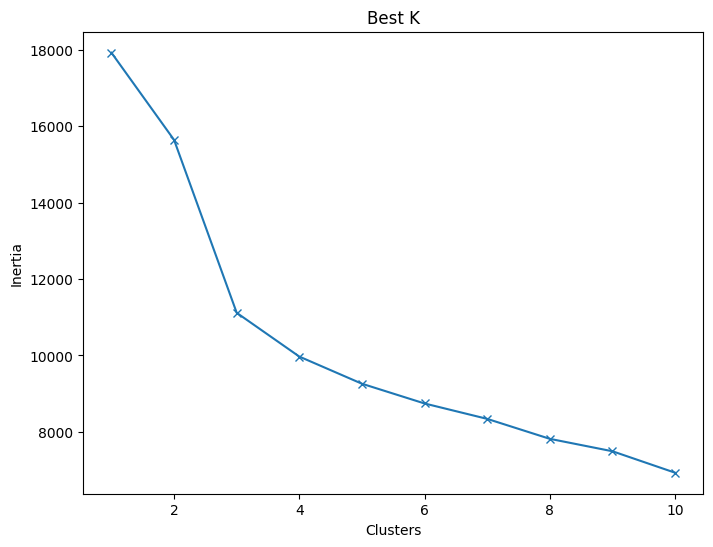

In [4]:
def plot_elbow_method(df_encoded):
    features = [
        'Age', 'Income', 'Recency', 'MntWines', 'MntMeatProducts', 
        'NumWebPurchases', 'NumStorePurchases', 'Marital_Status_Single'
    ]

    X = df_encoded[features]

    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)
    
    inertia = []
    cluster_range = range(1, 11)
    for k in cluster_range:
        kmeans = KMeans(n_clusters=k, random_state=42)
        kmeans.fit(X_scaled)
        inertia.append(kmeans.inertia_)
    
    plt.figure(figsize=(8, 6))
    plt.plot(cluster_range, inertia, marker='x')
    plt.xlabel('Clusters')
    plt.ylabel('Inertia')
    plt.title('Best K')
    plt.show()

plot_elbow_method(df_encoded)


Using only the relevant data, I plotted the number of clusters versus inertia (sum of squared distances between point and data mean in the cluster) and found the inflection point between 3 and 4 clusters. We could pick either one to be the ideal K.

# 3. (7 pts) Perform hierarchical clustering for customer segments. What is the ideal number of clusters? Which approach did you use to find the ideal number of clusters and why?

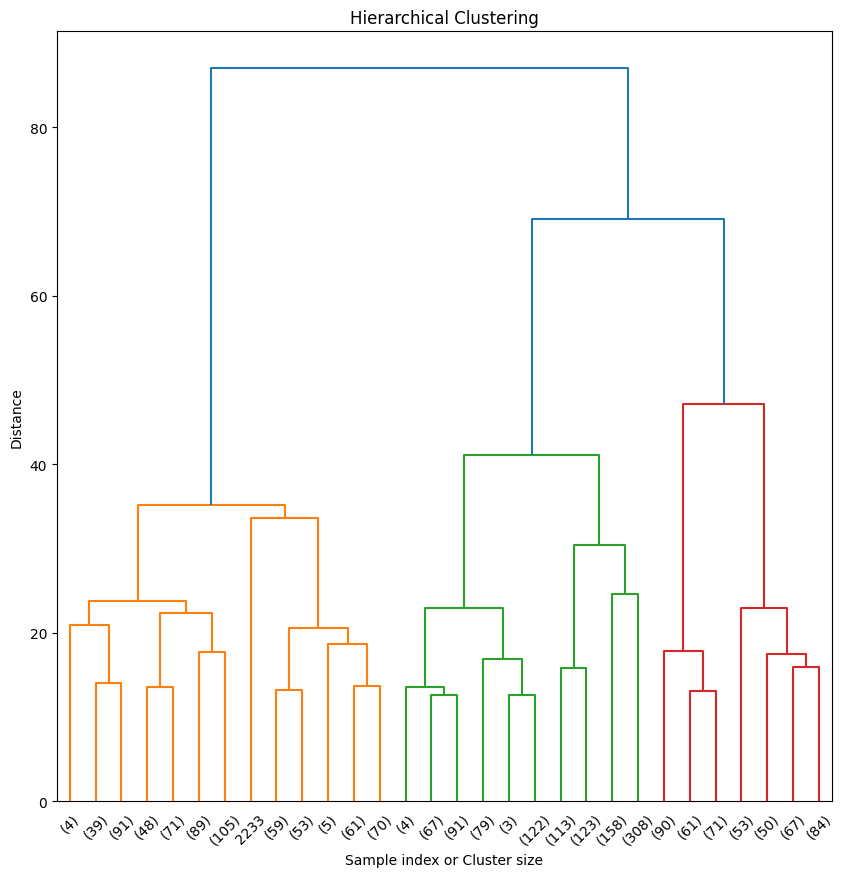

In [5]:
def plot_dendrogram(df_encoded):
    features = [
        'Age', 'Income', 'Recency', 'MntWines', 'MntMeatProducts', 
        'NumWebPurchases', 'NumStorePurchases', 'Marital_Status_Single'
    ]

    X = df_encoded[features]
    
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)

    linked = linkage(X_scaled, method='ward')

    plt.figure(figsize=(10, 10))
    dendrogram(linked, truncate_mode='lastp', p=30)
    plt.xlabel("Sample index or Cluster size")
    plt.ylabel("Distance")
    plt.title("Hierarchical Clustering")
    plt.show()

plot_dendrogram(df_encoded)


I used a dendogram to depict how the clusters would split so that I could determine what is the best k just by looking at it. From this graph, it seems like 3 is the best number of clusters although I could see a case being made for 5.

# 4. (3 pts) Compare the results of 2 and 3. Which approach do you think is best? Why?

Both K means and Hierarchical returned the same answer. The better method probably depends on what you need. K means gives an easy to understand aggregate, while hierarchical clustering shows exactly how the data is split into clusters and subclusters. K means is faster, but if I were to do a more in depth analysis I would use Hierarcichal.